# Modelado Jerárquico

> Ante la duda, todo. Martín Buscaglia.

In [1]:
import arviz as az
import pymc as pm
import preliz as pz
import numpy as np
from scipy.special import expit as logistic
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
az.style.use('arviz-doc')

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Los objetivos de este capítulo son:

 * Aprender sobre modelos jerárquicos
    * agrupamiento-parcial
    * efecto de _contracción_

## Compartir información

En el ejemplo de las propinas vimos que teníamos 4 grupos, jueves, viernes, sábado y domingo. Decidimos modelar cada grupo por separado. Eso a veces está bien, pero debemos ser conscientes de nuestros supuestos. Al modelar cada grupo de forma independiente, asumimos que los grupos no están relacionados. En otras palabras, asumimos que conocer la propina de un día no nos da ninguna información sobre la propina de los demás días. Esa podría ser una suposición demasiado fuerte. Como alternativa podríamos haber modelado los 4 días como un solo grupo, en este caso asumimos que no hay diferencias entre día, o al menos que esas diferencias no nos interesan.

¿Es posible construir un modelo que contemple que los grupos son diferentes y al mismo tiempo comparten información? No solo es posible, además ese es el tema principal de este capítulo.

Los modelos jerárquicos también se conocen como modelos multinivel, modelos de efectos mixtos, modelos de efectos aleatorios o modelos anidados. Son particularmente útiles cuando se trata de datos que se pueden describir como agrupados o con diferentes niveles, como datos anidados dentro de regiones geográficas, por ej ciudades que pertenecen a una provincia y provincias que pertenecen a un país, o con una estructura jerárquica, por ej, estudiantes dentro de escuelas, o pacientes dentro de los hospitales o también mediciones repetidas de los mismos individuos.

Los modelos jerárquicos son una forma natural de compartir información entre grupos y se construyen asignado distribuciones a priori a las distribuciones a priori. Este nivel superior de distribuciones a priori se suelen denominar hiper-priors. Tener hiper-priors permite que los grupos de un modelo compartan información, al mismo tiempo que permite diferencias entre grupos. En otras palabras, podemos pensar en los parámetros de las distribuciones a priori, de cada grupo, como pertenecientes a una población común de parámetros (determinada por el hiper-prior). La siguiente figura muestra un diagrama con las diferencias entre un modelo agrupado (un solo grupo), un modelo no agrupado (todos los grupos separados) y un modelo jerárquico, también conocido como modelo parcialmente agrupado.

![Diagrama que muestra las diferencias entre un modelo agrupado, un modelo no agrupado y un modelo jerárquico.](img/hierarchical_model.png)

## Desplazamientos jerárquicos

Las [proteínas](https://www.youtube.com/watch?v=wvTv8TqWC48) son moléculas formadas por 20 unidades, llamadas amino ácidos, cada amino ácido puede aparecer en una proteína 0 o más veces. Así como una melodía está definida por una sucesión de notas musicales, una proteína está definida por una sucesión de amino ácidos. Algunas variaciones de notas pueden dar como resultados pequeñas variaciones sobre la misma melodía, otras variaciones pueden resultar en melodías completamente distintas, algo similar sucede con las proteínas. Una forma de estudiar proteínas es usando resonancia magnética nuclear (la misma técnica usada para imágenes médicas). Esta técnica permite medir diversos _observables_, uno de ellos se llama _desplazamiento químico_ y para simplificar diremos que podemos medir tantos desplazamientos químicos como amino ácidos tenga una proteína. Los aminoácidos son una familia de compuestos químicos por lo que tendría sentido tratarlos a todos de igual forma, pero al mismo tiempo tienen diferentes propiedades químicas, las cuales de hecho son relevantes para comprender como funcionan las proteínas! Por lo que también tiene sentido tratarlos por separado. Como ya vimos una alternativa es construir un modelo jerárquico y hacer algo a mitad de camino.

El siguiente conjunto de datos contiene valores de desplazamientos químicos para un conjunto de proteínas. Si inspeccionan el DataFrame `cs_data` verán que tiene 4 columnas:

* La primera es un código que identifica a la proteína (si tienen curiosidad pueden ingresar el identificador en esta base de datos <https://www.rcsb.org>).
* La segunda columna tiene el nombre del amino ácido (pueden corroborar que hay tan solo 20 nombres únicos).
* La tercera contiene valores teóricos de desplazamientos químicos (calculados usando métodos cuánticos).
* La cuarta tiene valores experimentales.

La motivación de este ejemplo es comparar las diferencias entre valores teóricos y experimentales, entre otras razones para evaluar la capacidad de los métodos teóricos para reproducir valores experimentales.


In [4]:
cs_data = pd.read_csv('datos/chemical_shifts_theo_exp.csv')
diff = cs_data.theo - cs_data.exp
cat_encode = pd.Categorical(cs_data['aa'])
idx = cat_encode.codes
coords = {"aa": cat_encode.categories}

Para resaltar la diferencia entre un modelo jerárquico y uno no-jerárquico vamos a construir ambos. Primero el no-jerárquico.

In [5]:
with pm.Model(coords=coords) as cs_nh:         
    μ = pm.Normal('μ', mu=0, sigma=10, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 
 
    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 
     
    idata_cs_nh = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


Y ahora el jerárquico.

Este modelo tiene un hyper-prior para la media de $\mu$ y otro para la desviación estándar de $\mu$. Para $\sigma$ no usamos un hyper-prior, es decir asumimos valores independientes. Esta es una decisión que tomé para simplificar el modelo, en principio no habría problema con usar un hyper-prior también para $\sigma$ o incluso  estimar un solo valor, compartido, de $\sigma$.

In [6]:
with pm.Model(coords=coords) as cs_h:
    # hyper_priors
    μ_mu = pm.Normal('μ_mu', mu=0, sigma=10)
    μ_sd = pm.HalfNormal('μ_sd', 10)

    # priors
    μ = pm.Normal('μ', mu=μ_mu, sigma=μ_sd, dims="aa") 
    σ = pm.HalfNormal('σ', sigma=10, dims="aa") 

    y = pm.Normal('y', mu=μ[idx], sigma=σ[idx], observed=diff) 

    idata_cs_h = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_mu, μ_sd, μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


La siguiente figura muestra una representación gráfica de los modelos `cs_nh` (no-jerárquico) y `cs_h` (jerárquico). Se puede ver como el modelo jerárquico tiene un nivel más.


<div>
<img src="img/cs_nh_vs_h.png" width="700"/>
</div>


Vamos a comparar los resultados usando un `plot_forest`. ArviZ permite pasar más de un modelo. Esto es útil cuando queremos comparar los valores de parámetros equivalentes entre modelos como en el presente ejemplo. Noten que estamos pasando varios argumentos para obtener el gráfico, como por ejemplo `combined=True` que combina los resultados de todas las cadenas. Los invito a explorar el significado del resto de los parámetros.

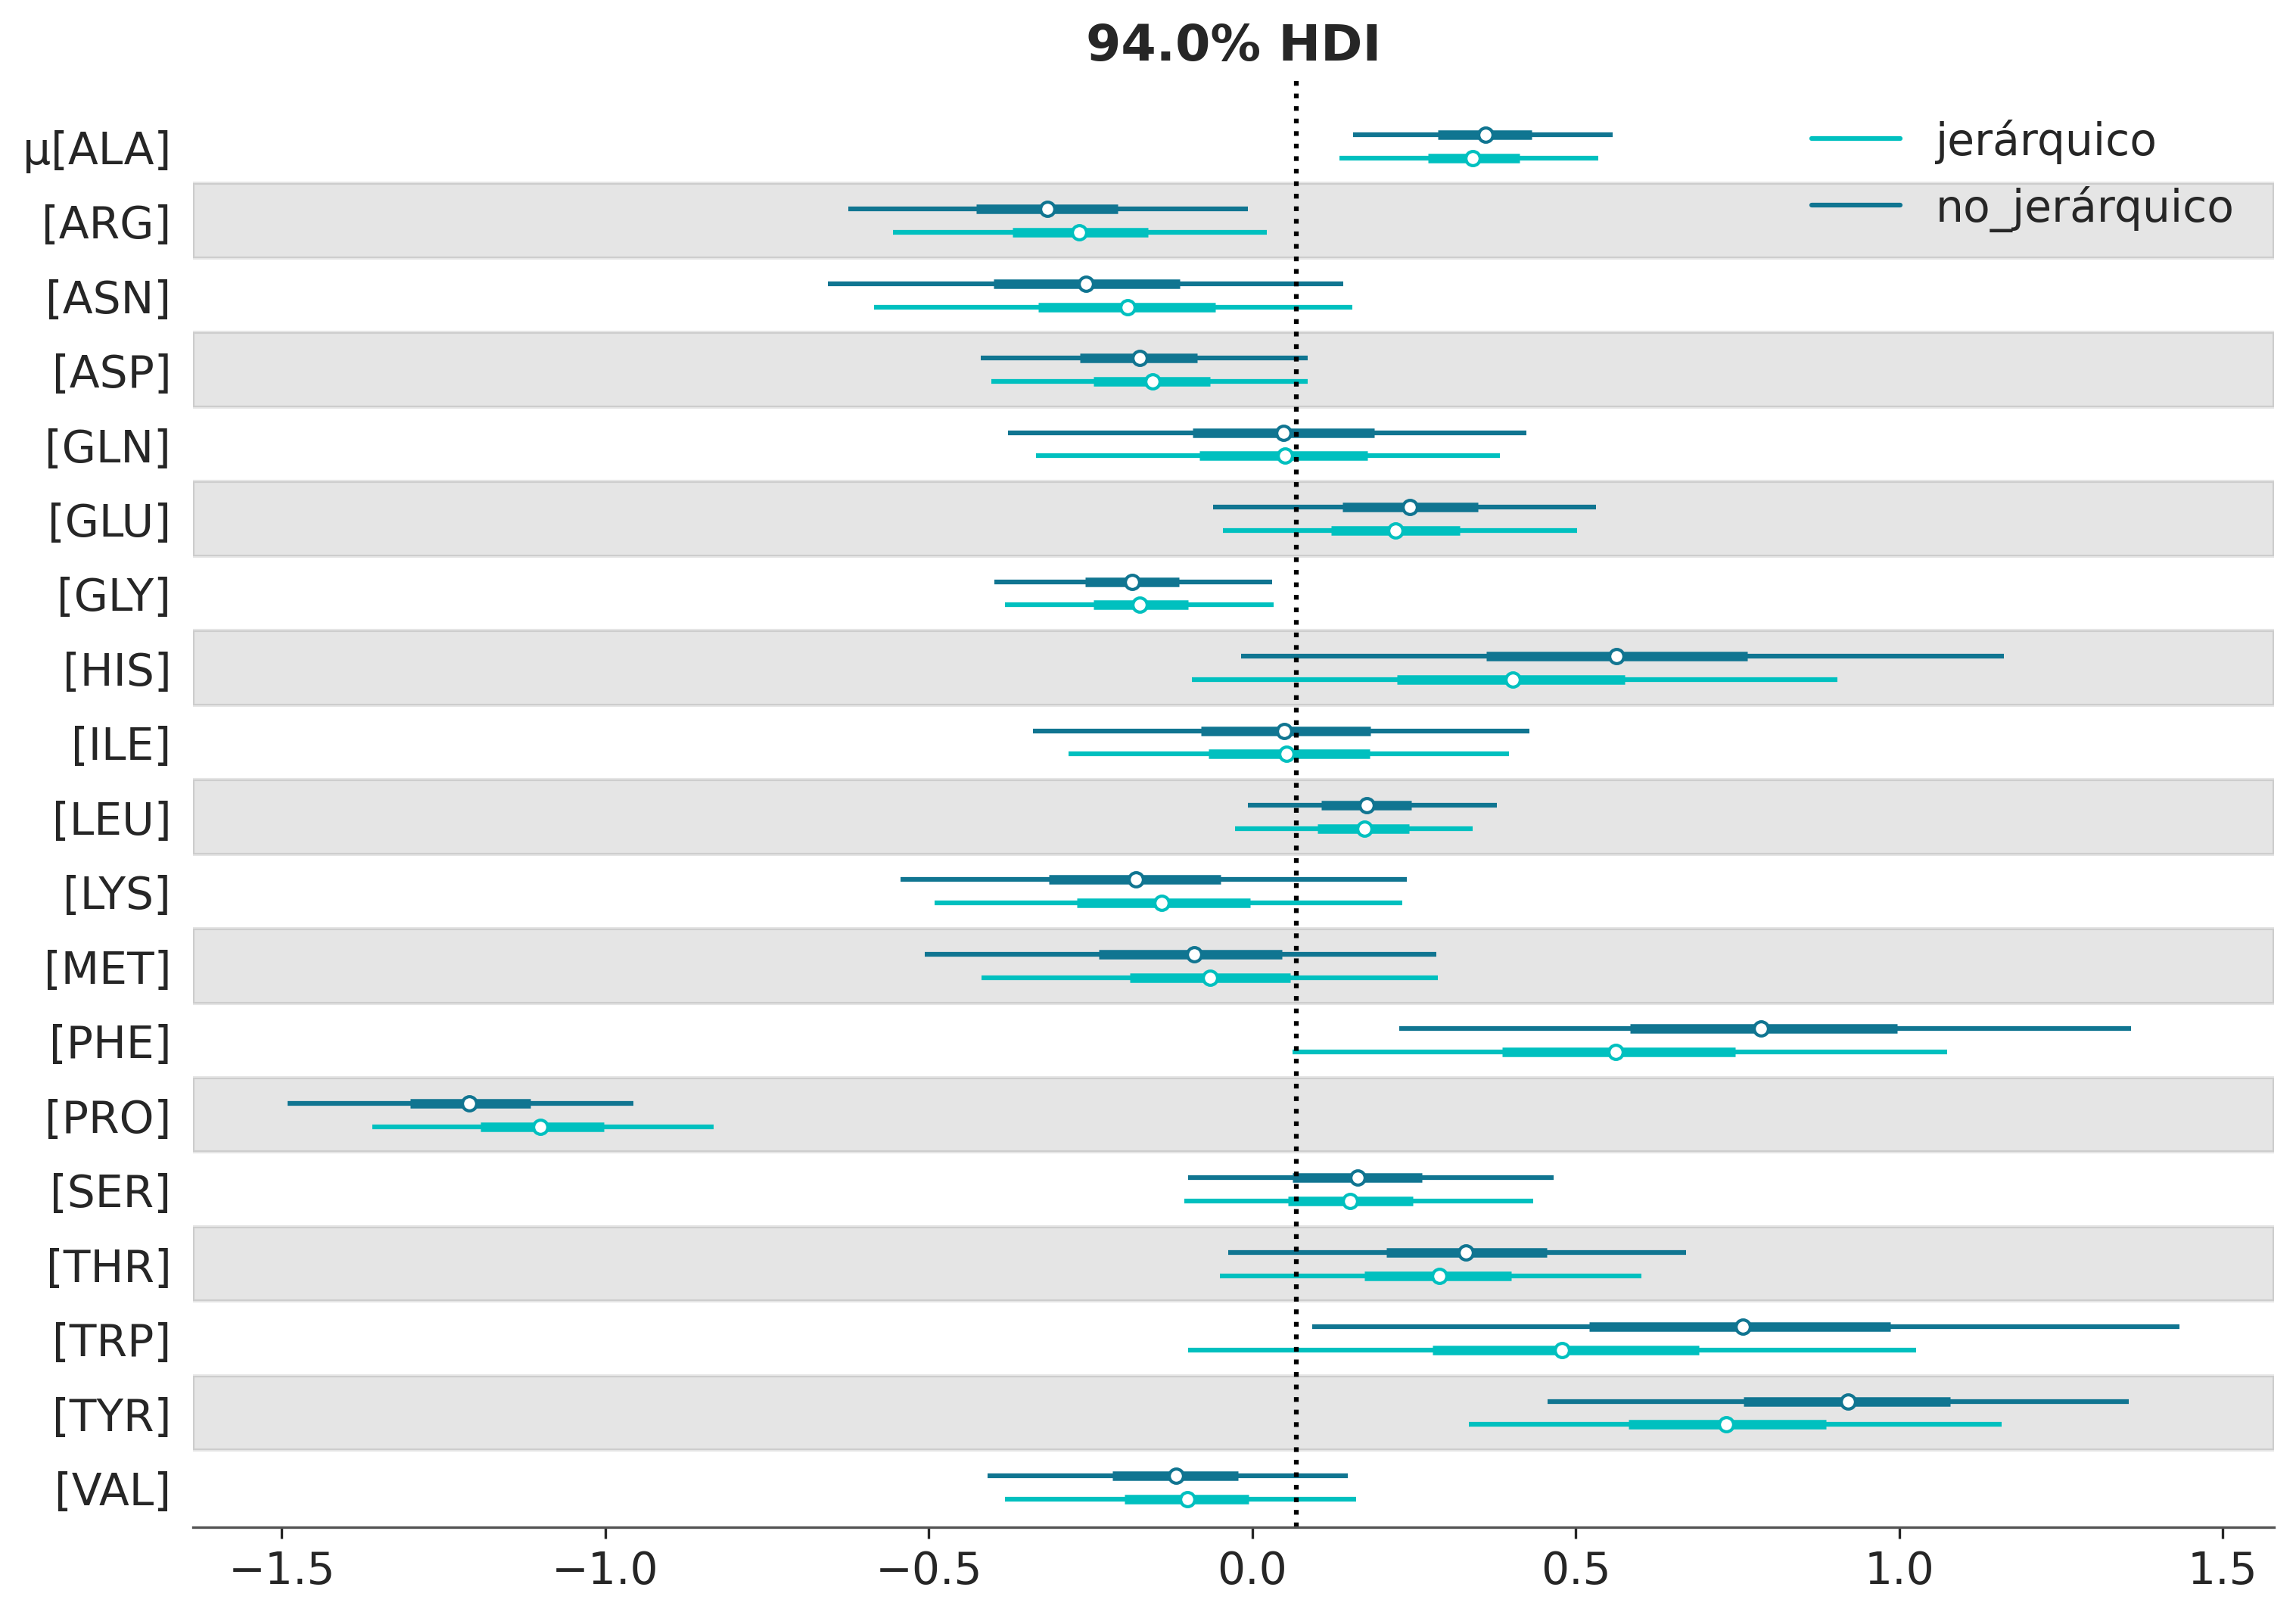

In [7]:
axes = az.plot_forest([idata_cs_nh, idata_cs_h], model_names=['no_jerárquico', 'jerárquico'],
                      var_names='μ', combined=True, r_hat=False, ess=False, figsize=(10, 7),
                      colors='cycle')
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_cs_h.posterior['μ_mu'].mean(), *y_lims, color="k", ls=":");

Bien, tenemos un gráfico para 40 valores medios estimados, uno por aminoácido (20) y esto duplicado ya que tenemos dos modelos. También tenemos los intervalos de credibilidad del 94% y el rango intercuartil (el intervalo que contiene el 50% central de la distribución). La línea vertical es la media parcialmente agrupada, es decir la media según el modelo jerárquico. El valor es cercano a cero, esto es parte de lo que esperaríamos ver si los valores teóricos son buenos reproduciendo los valores experimentales. 

La parte más relevante de este gráfico es que las estimaciones del modelo jerárquico son _atraídas_ hacia la media parcialmente agrupada o, de forma equivalente, se _contraen_ con respecto a las estimaciones no agrupadas. Este efecto es más notorio para los grupos más alejados de la media (como 13), además la incertidumbre es igual o menor que la del modelo no jerárquico. Decimos que las estimaciones están parcialmente agrupadas porque tenemos una estimación para cada grupo, pero las estimaciones para cada grupos se restringen mutuamente mediante el hiper prior. Por lo tanto, se obtiene una situación intermedia entre tener un solo grupo, todos los aminoácidos juntos, y tener 20 grupos separados, uno por aminoácido. 

Parafraseando el Zen de Python, podemos decir: _hierarchical models are one honking great idea - let's do more of those!_.

En los próximos capítulos, seguiremos construyendo modelos jerárquicos y aprendiendo cómo usarlos para construir mejores modelos. También discutiremos cómo se relacionan los modelos jerárquicos con uno de los problemas más comunes en estadística, ciencia de datos y _Machine learning_ el problema del overfitting/underfitting.

## Renacuajos multinivel

Este ejemplo está tomado de [statistical rethinking](https://xcelab.net/rm/statistical-rethinking/)

* Tenemos 48 tanques llenos de renacuajos

* Queremos modelar la probabilidad de supervivencia de los renacuajos

* Las condiciones como la temperatura, el pH, la luz, etc. varían ligeramente entre los tanques (pero no los estamos teniendo en cuenta explícitamente)

* Podemos pensar en cada tanque como un grupo


In [8]:
d = pd.read_csv('datos/reedfrogs.csv', sep=",")
d.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [9]:
with pm.Model() as modelo_renacuajos:
    # Hiperpriors
    μ = pm.Normal('μ', 0., 1.)
    σ = pm.HalfNormal('σ', 10.)
    # Prior
    α_tanque = pm.Normal('α_tanque', μ, σ, shape=d.shape[0])
    p = pm.Deterministic('p', pm.math.sigmoid(α_tanque))  # transformación logística
    #likelihood
    surv = pm.Binomial('surv', n=d.density, p=p, observed=d.surv)
    
    idata_renacuajos = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, α_tanque]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


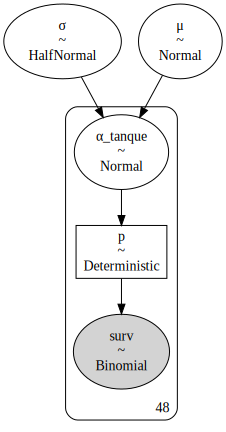

In [10]:
pm.model_to_graphviz(modelo_renacuajos)

En la siguiente figura se muestran las proporciones empíricas de sobrevivientes en cada tanque de renacuajos (puntos azules) y las proporciones estimadas por el modelo (puntos turquesa). La línea discontinua indica la proporción promedio de sobrevivientes teniendo en cuenta todos los tanques. Las lineas verticales dividen los tanques de acuerdo a las diferentes densidades iniciales de renacuajos: tanques pequeños (10), tanques medianos (25) y tanques grandes (35). En cada tanque, la media a posteriori del modelo multinivel está más cerca de la línea punteada que la proporción empírica. Esto refleja la información compartida entre tanques y el efecto de contracción.

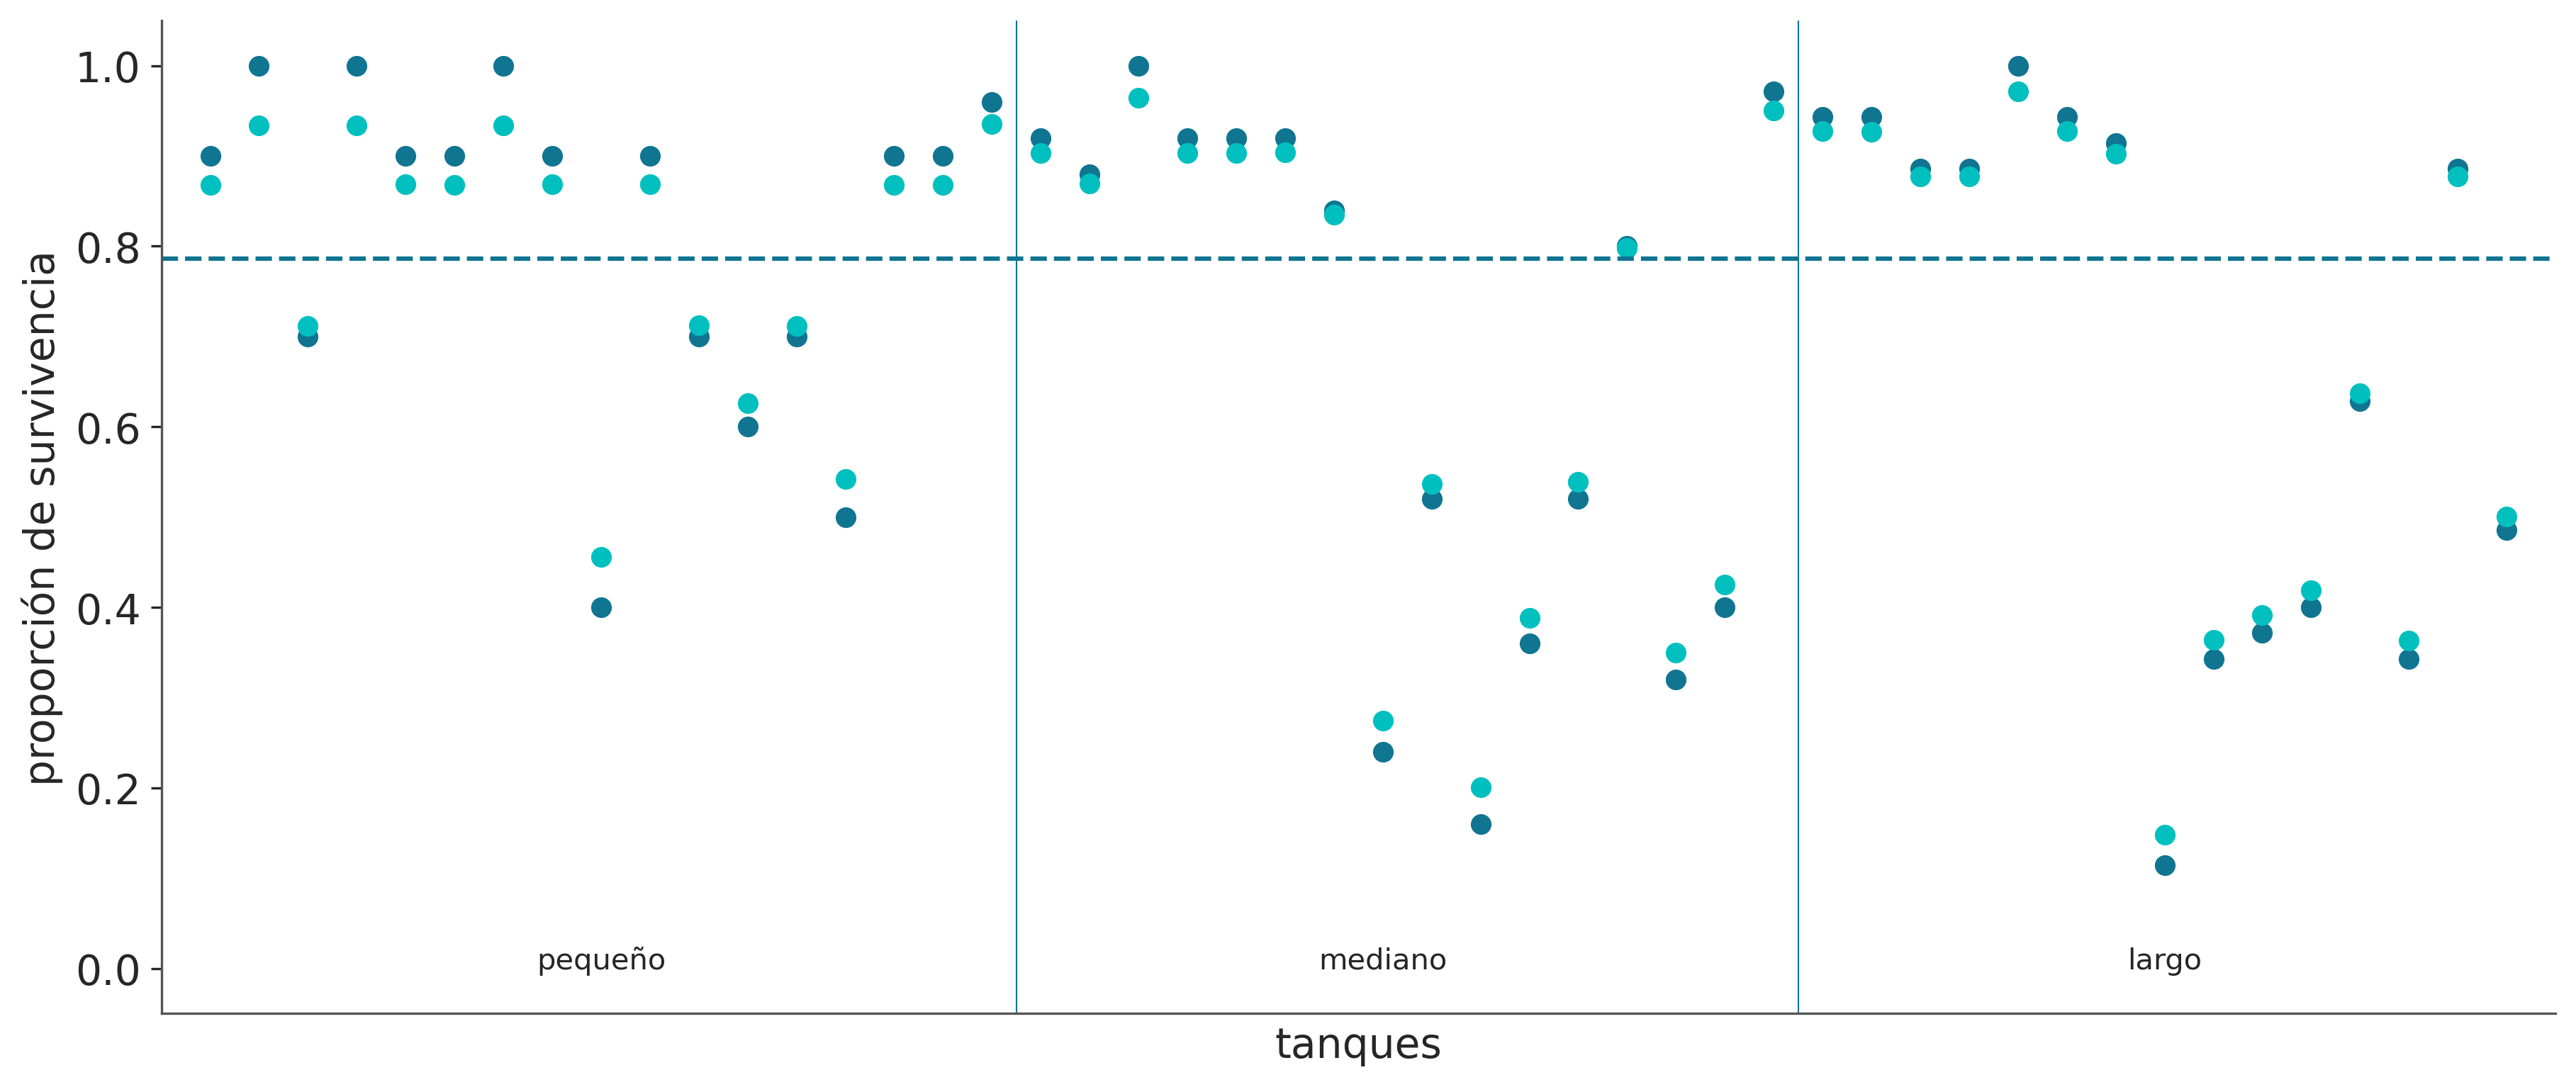

In [11]:
_, ax = plt.subplots(1, 1, figsize=(12, 5))

post_r = az.extract(idata_renacuajos)

ax.scatter(np.arange(0, 48), d.propsurv, color='C0')
ax.scatter(np.arange(0, 48), post_r['p'].mean("sample"), color='C1')
ax.hlines(logistic(post_r['μ'].median("sample")), -1, 49, linestyles='--')

idx = d.density[d.density.diff() > 0].index
ax.vlines(idx + 0.5, -.05, 1.05, lw=.5)
for i, t in zip(np.linspace(0, 48, 7)[1::2], ('pequeño', 'mediano', 'largo')):
    ax.text(i, 0, t, horizontalalignment='center')
ax.set_xlabel('tanques')
ax.set_ylabel('proporción de survivencia')
ax.set_xlim(-1, 48)
ax.set_xticks([])
ax.set_ylim(-.05, 1.05)
ax.grid(False)

## Tuberías jerárquicas

Supongamos que queremos analizar la calidad del agua en una ciudad, entonces tomamos muestras dividiendo la ciudad en barrios. Podemos pensar que tenemos dos opciones para analizar estos datos:

* Estudiar cada barrio como una entidad separada
* Reunir todos los datos y estimar la calidad del agua de la ciudad como un solo gran grupo

Probablemente a este altura ya hayas notado el patrón. Podemos justificar la primera opción diciendo que obtenemos una visión más detallada del problema, que de otro modo podría volverse invisible o menos evidente si promediamos los datos. La segunda opción se puede justificar diciendo que si agrupamos los datos, obtenemos un tamaño de muestra más grande y por lo tanto una estimación más precisa. Pero ya sabemos que tenemos una tercera opción, ¡podemos hacer un modelo jerárquico!

Para este ejemplo, vamos a utilizar datos sintéticos. Usar datos sintéticos es una excelente manera de entender las cosas. Si no entiendes algo, simúlalo! Hay muchos usos para los datos sintéticos. Aquí vamos a imaginar que hemos recolectado muestras de agua de tres regiones diferentes de la misma ciudad y hemos medido el contenido de plomo del agua; las muestras con concentraciones de plomo por encima de las recomendaciones de la Organización Mundial de la Salud (OMS) se marcan con cero y las muestras con valores por debajo de las recomendaciones se marcan con uno. Este es un escenario muy simple, en un ejemplo más realista, tendríamos una medición continua de la concentración de plomo y probablemente muchos más grupos. Sin embargo, este escenario es lo suficientemente bueno para explorar los detalles de los modelos jerárquicos. Podemos generar los datos sintéticos con el siguiente código:


In [12]:
N = [30, 30, 30]
G = [18, 18, 18]

group_idx = np.repeat(np.arange(len(N)), N)

data = []
for i in range(0, len(N)):
    data.extend(np.repeat([1, 0], [G[i], N[i]-G[i]]))

Estamos simulando un experimento en el que hemos medido tres grupos, cada uno formado por un determinado número de muestras; almacenamos el número total de muestras por grupo en el arreglo `N`. Usando la lista `G_samples`, mantenemos un registro del número de muestras de buena calidad por grupo. El resto del código está ahí solo para generar una lista de datos, llena de ceros y unos.

El modelo para este problema es similar al que usamos para el problema de la moneda.

\begin{align}
\theta &\sim \operatorname{Beta}(\alpha, \beta) \\
y &\sim \operatorname{Bin}(n=1, p=\theta)
\end{align}

excepto por dos características importantes:

* Hemos definido dos hyper-prior que influirán en la beta previa.
* En lugar de poner hiperpriors en los parámetros $\alpha$ y $\beta$, estamos definiendo la distribución beta en términos de $\mu$, la media, y $\nu$, la concentración (o precisión) de la distribución beta. La precisión es análoga a la inversa de la desviación estándar; cuanto mayor sea el valor de $\nu$, más concentrada será la distribución beta. En notación estadística, nuestro modelo es:


\begin{aligned}
\mu &\sim \text{Beta}(\alpha_{\mu}, \beta_{\mu}) \\
\nu &\sim \mathcal{HN}(\sigma_{\nu}) \\
\theta_i &\sim \text{Beta}(\mu, \nu) \\
y_i &\sim \text{Bin}(n=1, p=\theta_i)
\end{aligned}

Observen que estamos usando el subíndice $i$ para indicar que el modelo tiene grupos con diferentes valores para algunos de los parámetros. Es decir, no todos los parámetros se comparten entre los grupos. Observen también que para este modelo estamos parametrizando la distribución a priori, Beta, en términos de $\mu$ y $\nu$ en lugar de $\alpha$ y $\beta$. Esta es una práctica común en estadística Bayesiana, ya que muchas veces $\mu$ y $\nu$ son parámetros más intuitivos que $\alpha$ y $\beta$.

In [13]:
with pm.Model() as modelo_j:
    # hypyerpriors
    μ = pm.Beta('μ', 1, 1)
    ν = pm.HalfNormal('ν', 10)
    # prior
    θ = pm.Beta('θ', mu=μ, nu=ν, shape=len(N))
    # likelihood
    y = pm.Binomial('y',n=1, p=θ[group_idx], observed=data)

    idata_j = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, ν, θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


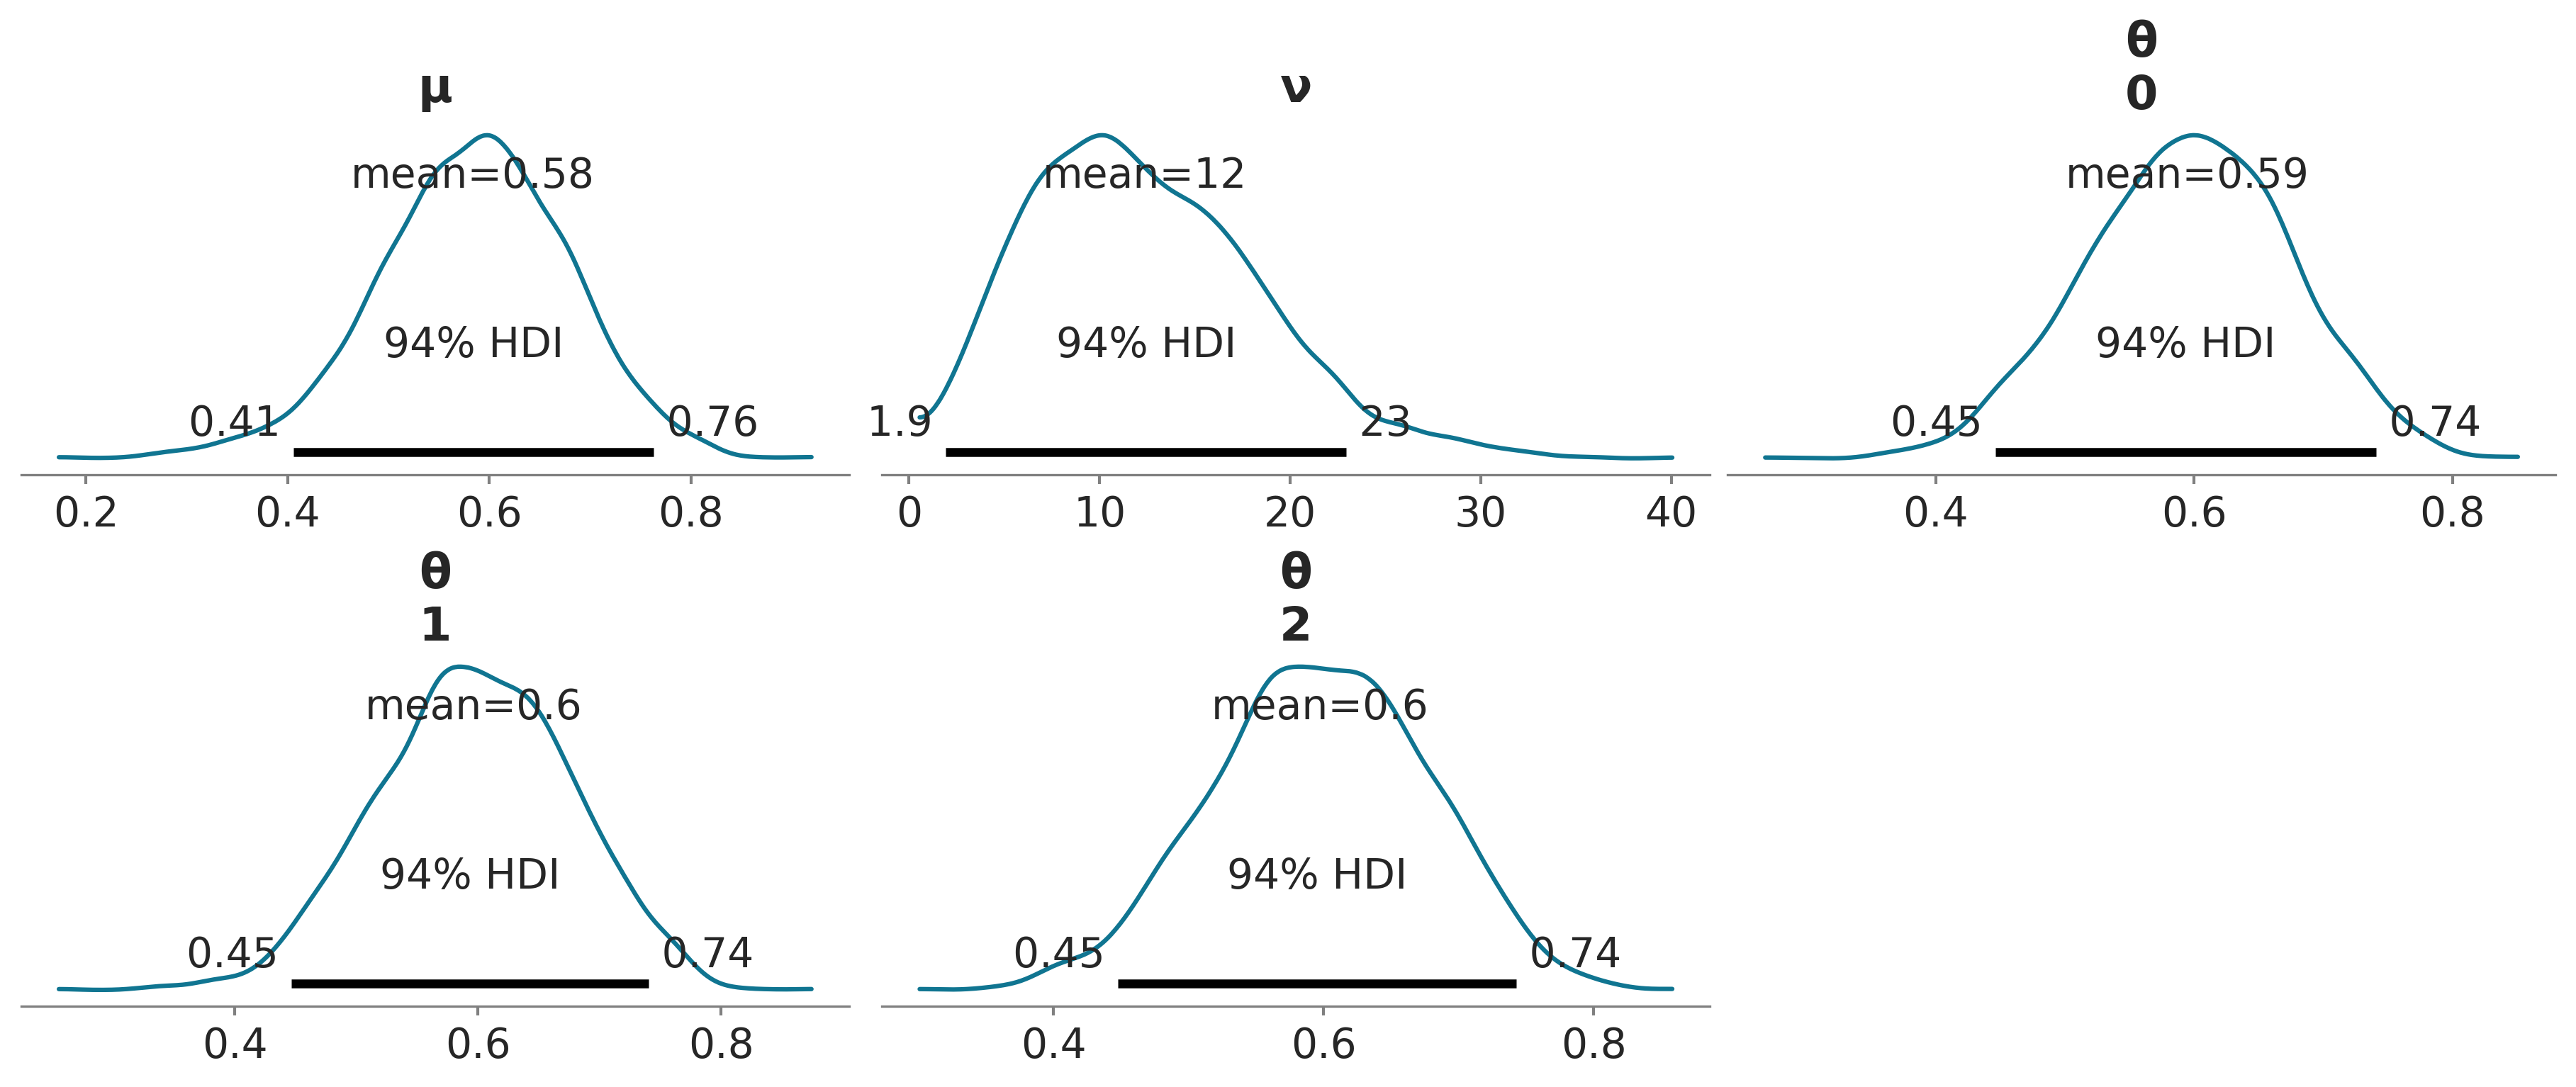

In [14]:
az.plot_posterior(idata_j, figsize=(12, 5));

In [15]:
az.summary(idata_j, kind="stats")

,mean,sd,hdi_3%,hdi_97%
μ,0.583,0.096,0.406,0.763
ν,12.366,6.036,1.922,22.952
θ[0],0.595,0.079,0.446,0.741
θ[1],0.597,0.079,0.447,0.740
θ[2],0.597,0.080,0.448,0.743


### Contracción

Para mostrarle una de las principales consecuencias de los modelos jerárquicos, necesitaré de su ayuda, así que únanse a mí en un breve experimento. Necesitaré que impriman y guarden el resumen calculado con `az.summary(idata_h)`. Luego, quiero que vuelvan a ejecutar el modelo dos veces más después de realizar pequeños cambios en los datos sintéticos. Recuerden guardar el resumen después de cada ejecución. En total, tendremos tres corridas:

* Una ejecución configurando todos los elementos de G a 18
* Una ejecución configurando todos los elementos de G a 3
* Una última ejecución configurando un elemento en 18 y los otros dos en 3

Antes de continuar, tómense un momento para pensar en el resultado de este experimento. Concéntrese en el valor medio estimado de $\theta$ en cada experimento. Con base en las dos primeras ejecuciones del modelo, ¿Podrías predecir el resultado para el tercer caso?

---
<br>
<br>
<br>


Si ponemos el resultado en una tabla, obtenemos algo más o menos así; recuerden que pueden ocurrir pequeñas variaciones debido a la naturaleza estocástica del proceso de muestreo:

| G | Media |
|------------------|------------------|
| 18, 18, 18 | 0,6, 0,6, 0,6 |
| 3, 3, 3 | 0,11, 0,11, 0,11 |
| 18, 3, 3 | 0,55, 0,13, 0,13 |

En la primera fila, podemos ver que con 18 muestras con buena calidad sobre un total de 30, obtenemos un valor medio para $\theta$ de 0,6. Tenemos 3 valores por que $\theta$ es un vector de tres elementos, uno por grupo. Luego, en la segunda fila, tenemos solo 3 muestras de buena calidad sobre un total de 30 y la media de $\theta$ es 0,11. Estos resultados no deberían sorprendernos, nuestras estimaciones son prácticamente iguales a las medias empíricas. Lo interesante viene en la tercera fila. En lugar de obtener una mezcla de las estimaciones medias de $\theta$ de las otras dos filas, como 0,6, 0,11 y 0,11, obtenemos valores diferentes, a saber, 0,55, 0,13 y 0,13.

¿A que se debe esto? ¿Cometimos un error en alguna parte? Nada de eso. Lo que estamos viendo es que las estimaciones se contrajeron hacia la media común. Esto está muy bien, de hecho ya lo hemos visto en los ejemplos anteriores. Este efecto es una consecuencia directa de nuestro modelo; mediante el uso de hiper priors, estamos estimando los parámetros de la distribución Beta a partir de los datos. Cada grupo está informando al resto, y cada grupo está siendo informado por la estimación de los demás.

## Jerarquías futboleras


Varias estructuras de datos se prestan a descripciones jerárquicas que pueden abarcar múltiples niveles. Por ejemplo, jugadores profesionales de fútbol. Como en muchos otros deportes, los jugadores tienen diferentes posiciones dentro de la cancha. Es posible que nos interese estimar algunas métricas de habilidad para cada jugador, para las posiciones y para el grupo general de jugadores de fútbol profesional. Este tipo de estructura jerárquica también se puede encontrar en muchos otros dominios, como:

* Investigación médica: Supongamos que estamos interesados en estimar la eficacia de diferentes fármacos para el tratamiento de una determinada enfermedad. Podemos categorizar a los pacientes según su información demográfica, la gravedad de la enfermedad y otros factores relevantes y construir un modelo jerárquico para estimar la probabilidad de curación o el éxito del tratamiento para cada subgrupo. Luego podemos usar los parámetros de la distribución de subgrupos para estimar la probabilidad general de curación o éxito del tratamiento para toda la población de pacientes.

* Ciencias ambientales: Supongamos que estamos interesados en estimar el impacto de un determinado contaminante en un ecosistema particular. Podemos categorizar diferentes hábitats dentro del ecosistema (p. ej., ríos, lagos, bosques, humedales) y construir un modelo jerárquico para estimar la distribución de los niveles de contaminantes dentro de cada hábitat. Luego podemos usar los parámetros de la distribución del hábitat para estimar la distribución general de los niveles de contaminantes dentro del ecosistema.

* Investigación de mercado: supongamos que estamos interesados en comprender el comportamiento de compra de los consumidores de un producto en particular en diferentes regiones. Podemos categorizar a los consumidores según su información demográfica (por ejemplo, edad, sexo, ingresos, educación) y construir un modelo jerárquico para estimar la distribución del comportamiento de compra para cada subgrupo. Luego podemos usar los parámetros de la distribución del subgrupo para estimar la distribución del comportamiento de compra para el grupo general de consumidores.

Volviendo a nuestros jugadores de fútbol, hemos recopilado datos de la *Premier League*, *Ligue 1*, *Bundesliga*, *Serie A* y *La Liga*, en el transcurso de cuatro años (2017 a 2020). Supongamos que estamos interesados en la métrica de goles por tiro. Esto es lo que los estadísticos suelen llamar *tasa de éxito*, y podemos estimarlo con un modelo Binomial donde el parámetro $n$ es el número de tiros y las observaciones $y$ es el número de goles. Esto nos deja con un valor desconocido para $p$, en ejemplos anteriores hemos estado llamando a este parámetro $\theta$ y hemos usado una distribución Beta para modelarlo. Haremos lo mismo ahora, pero jerárquicamente. $\theta$ representa la "tasa de éxito" de cada jugador y, por lo tanto, es un vector de tamaño `n_jugadores`. Usamos una distribución Beta para modelar $\theta$. Los hiperparámetros de la distribución Beta serán los vectores $\mu_p$ y $\nu_p$, que son vectores de tamaño 4, que representan las cuatro posiciones en nuestro conjunto de datos (defensor `DF`, centrocampista `MF`, delantero `FW` y arquero `GK`). Tendremos que indexar correctamente los vectores $\mu_p$ y $\nu_p$ para que coincidan con el número total de jugadores. Finalmente, tendremos dos parámetros globales, $\mu$ y $\nu$, que representan a los futbolistas profesionales.


El modelo PyMC se define en el siguiente bloque de código. El `pm.Beta('mu', 1.7, 5.8)` fue elegido con la ayuda de PreliZ como prior con el 90% de la masa entre 0 y 0.5. Este es un ejemplo de un prior poco informativo, ya que no hay duda de que una tasa de éxito de 0,5 es un valor alto. Las estadísticas deportivas están bien estudiadas y hay mucha información previa que podría usarse para definir priors más fuertes. Para este ejemplo, nos conformaremos con este prior. Una justificación similar se puede hacer para el prior `pm.Gamma('nu', mu=125, sigma=50)`, que definimos como la distribución Gamma de máxima entropía con el 90% de la masa entre 50 y 200.

In [16]:
futbol = pd.read_csv("datos/futbol.csv", dtype={'posición':'category'})
pos_idx = futbol.posición.cat.codes.values
pos_codes = futbol.posición.cat.categories
n_pos = pos_codes.size
n_jugadores = futbol.index.size

In [17]:
coords = {"pos": pos_codes}
with pm.Model(coords=coords) as modelo_futbol:
    # Hiper-parámetros
    μ = pm.Beta('μ', 1.7, 5.8) 
    ν = pm.Gamma('ν', mu=125, sigma=50)

    
    # Parámetros por posición
    μ_p = pm.Beta('μ_p',
                       mu=μ,
                       nu=ν,
                       dims = "pos")
    
    ν_p = pm.Gamma('ν_p', mu=125, sigma=50, dims="pos")
 
    # Parámetros por jugador
    θ = pm.Beta('θ', 
                    mu=μ_p[pos_idx],
                    nu=ν_p[pos_idx])
    
    _ = pm.Binomial('gs', n=futbol.tiros.values, p=θ, observed=futbol.goles.values)

    idata_futbol = pm.sample(4000, target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, ν, μ_p, ν_p, θ]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 280 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


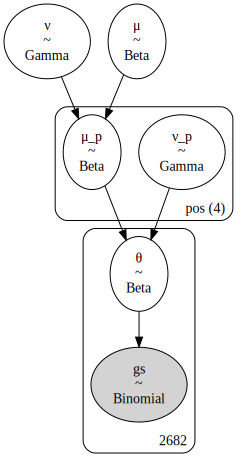

In [18]:
pm.model_to_graphviz(modelo_futbol)

En el panel superior de la siguiente figura tenemos la distribución a posteriori del parámetro global $\mu$. La distribución a posteriori es cercana a 0.1. Lo que significa que, en general, para un jugador de fútbol profesional, la probabilidad de hacer un gol es en promedio del 10%. Este es un valor razonable, ya que hacer goles no es una tarea fácil y no estamos discriminando posiciones, es decir, estamos considerando jugadores cuyo papel principal no es el de hacer goles. En el panel central, tenemos el valor estimado de $mu_p$ para la posición de defensa, como es de esperar, es más alto que el parámetro global $\mu$. En el panel inferior, tenemos el valor estimado de $\theta$ para Lionel Messi, con un valor de 0.17, que es más alto que el parámetro global $\mu$ y el valor de la posición delantera $\mu_p$. Esto también es de esperarse, ya que Lionel Messi es el mejor jugador de fútbol del mundo, y su rol principal es hacer goles.

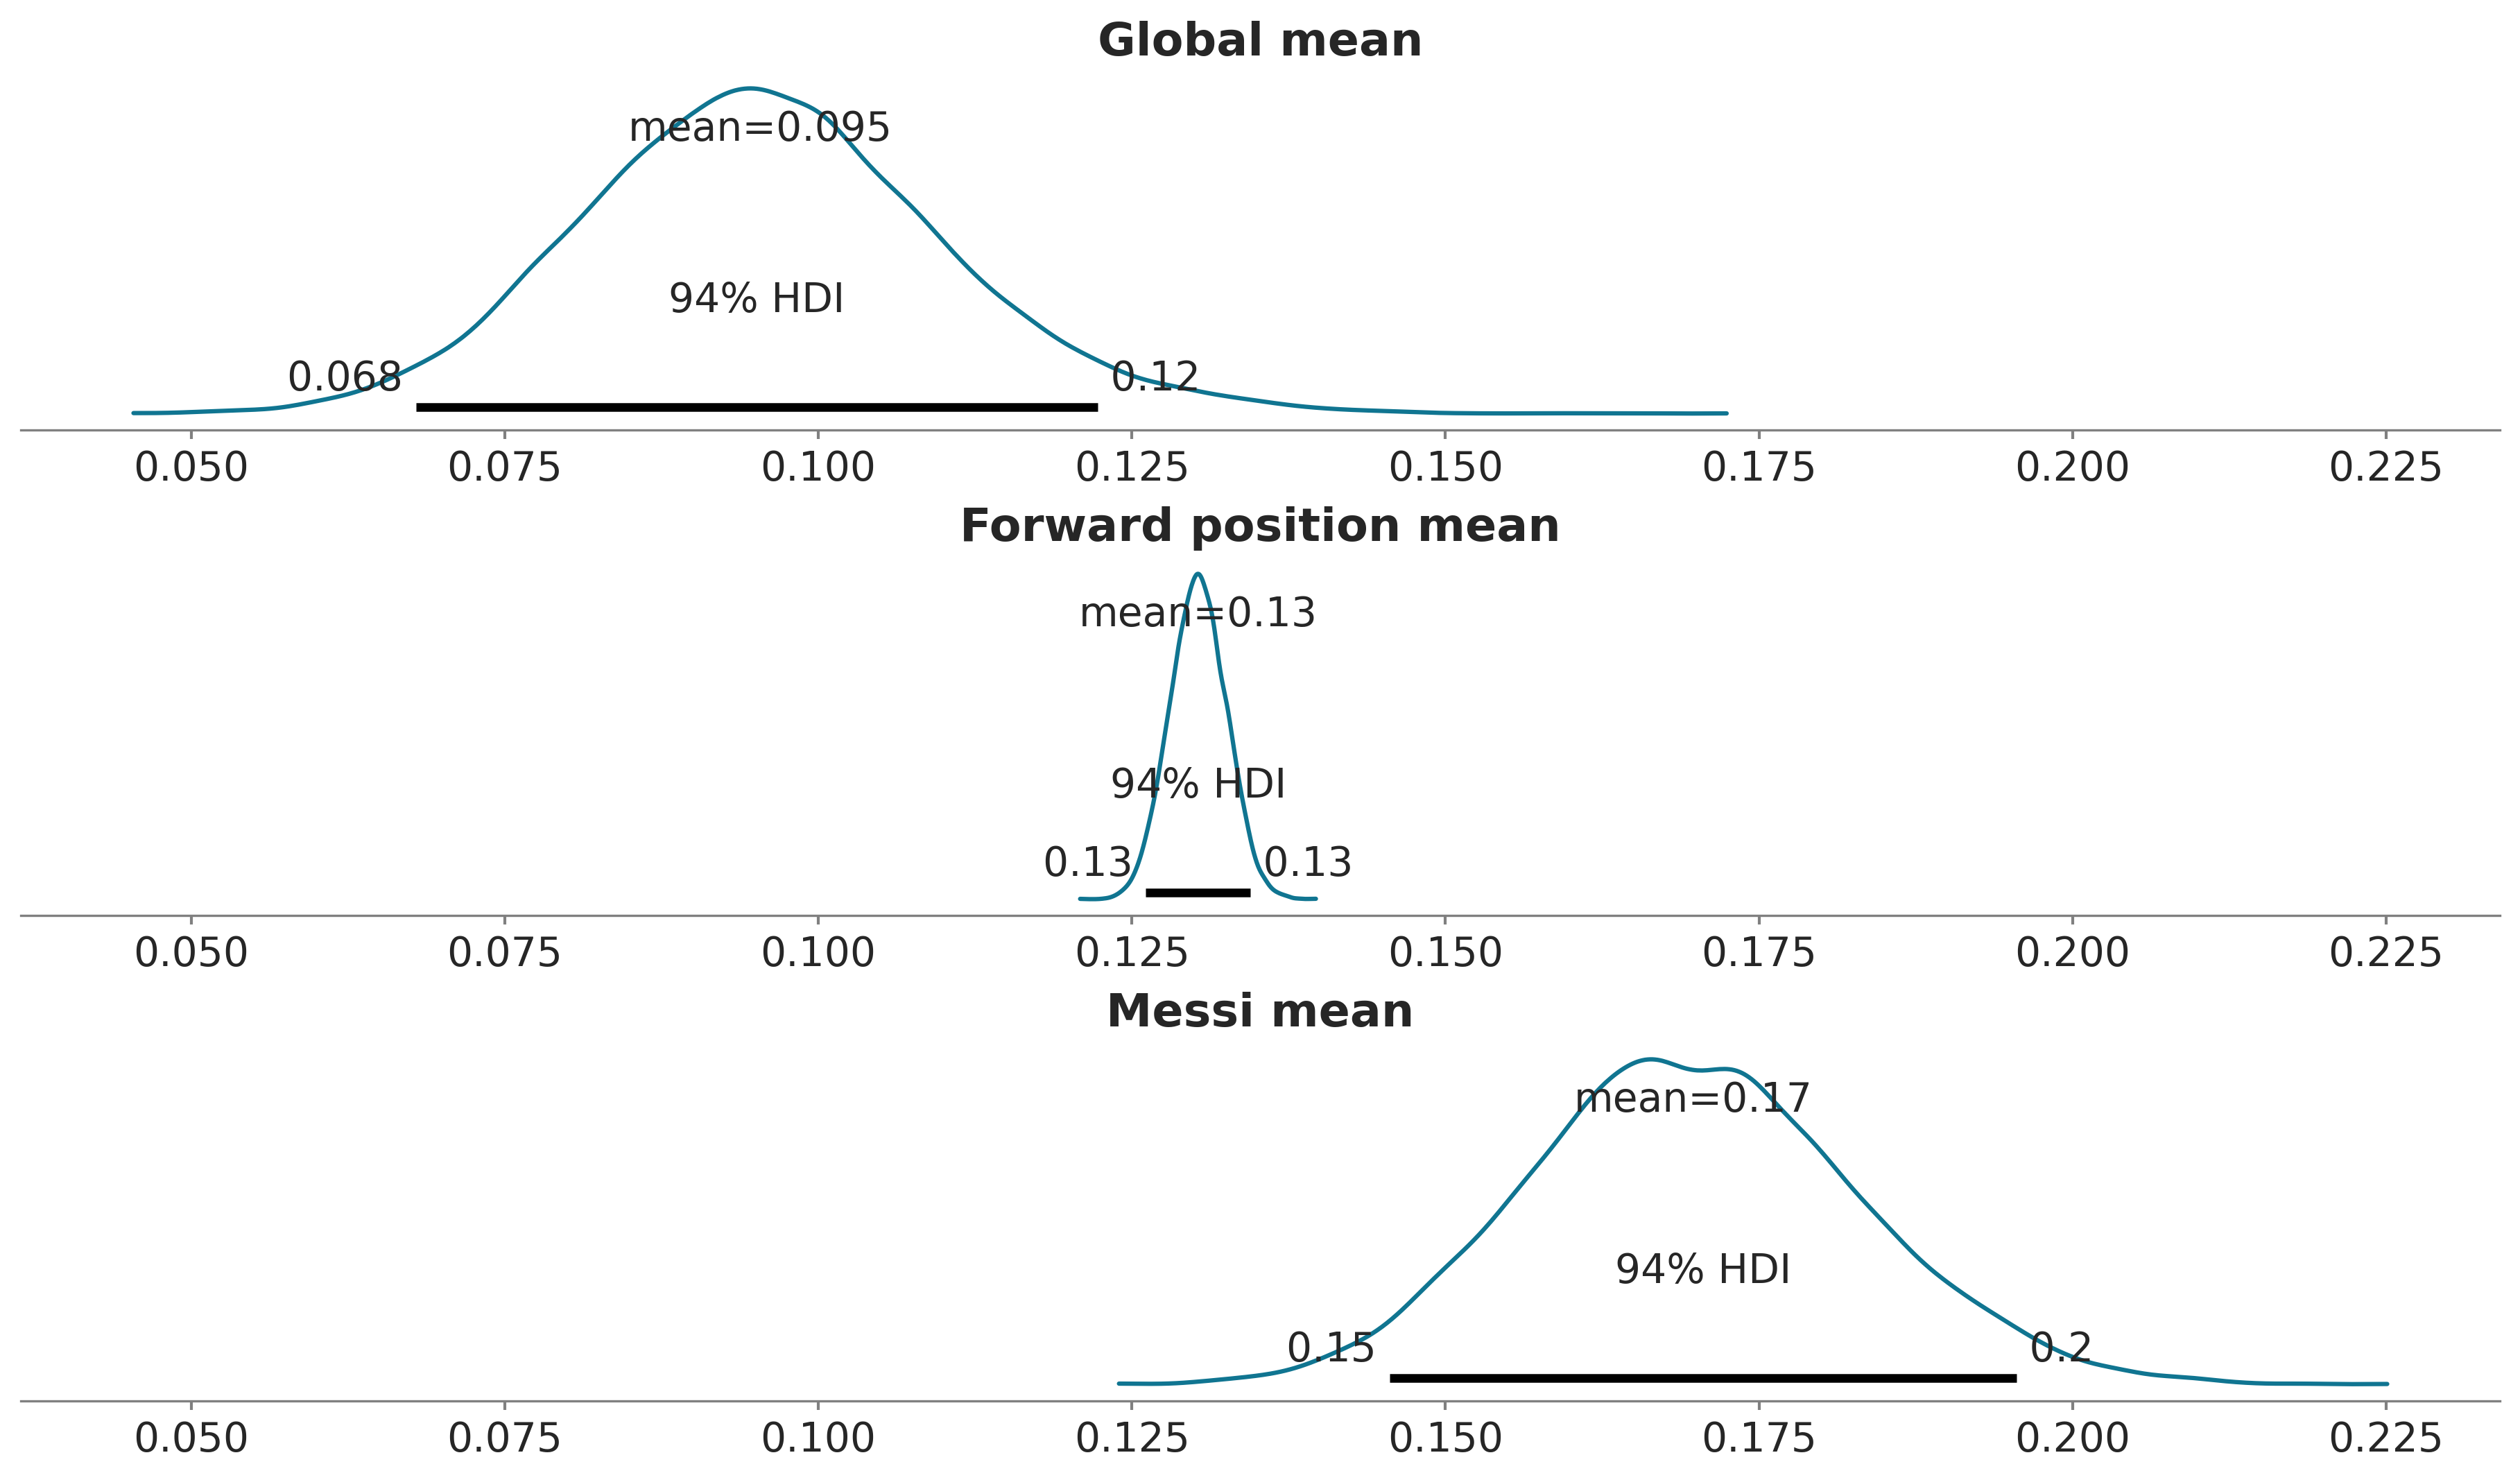

In [19]:
_, ax = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
az.plot_posterior(idata_futbol, var_names='μ', ax=ax[0])
ax[0].set_title(r"Global mean")
az.plot_posterior(idata_futbol.posterior.sel(pos="FW"), var_names='μ_p', ax=ax[1])
ax[1].set_title(r"Forward position mean")
az.plot_posterior(idata_futbol.posterior.sel(θ_dim_0=1457), var_names='θ', ax=ax[2])
ax[2].set_title(r"Messi mean");

La siguiente figura muestra un `forest plot` para la distribución a posteriori del parámetro $\mu_p$. La distribución a posteriori para delanteros se centra en torno a 0.13, como ya vimos, y es la más alta de las cuatro. Esto tiene sentido ya que el papel de los jugadores en una posición delantera es hacer goles y asistencias. El valor más bajo de $\mu_p$ es para la posición de arquero. Esto esperable, ya que la función principal es evitar que el equipo contrario haga goles. El aspecto interesante es que la incertidumbre es muy alta, esto se debe a que tenemos muy pocos arqueros haciendo goles en nuestro conjunto de datos, 3 para ser precisos. Las distribuciones a posteriori para las posiciones de defensa y mediocampo están en *el medio*, siendo ligeramente más altas para los mediocampistas. Podemos explicar esto porque el papel principal de un mediocampista es defender y atacar, y por lo tanto la probabilidad de marcar un gol es mayor que la de un defensor pero menor que la de un delantero.

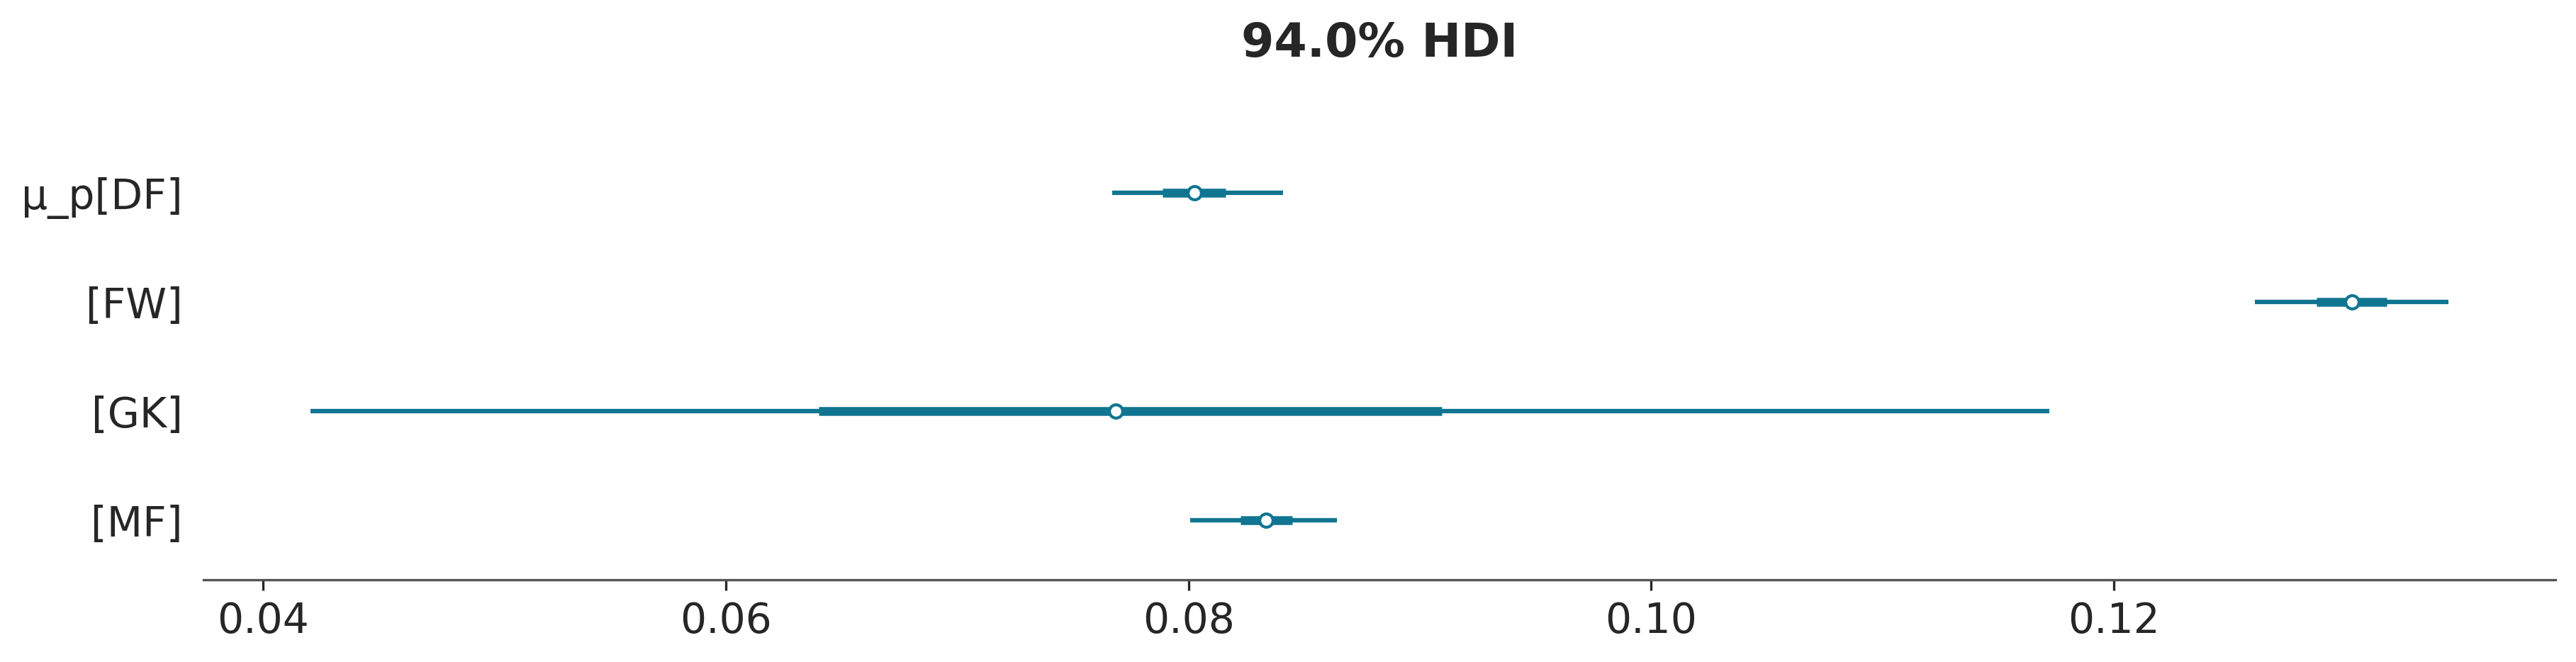

In [20]:
az.plot_forest(idata_futbol, var_names=['μ_p'], combined=True, figsize=(12, 3));

## Resumen

En este capítulo hemos descrito uno de los conceptos más importantes de este curso: los modelos jerárquicos. Podemos construir modelos jerárquicos cada vez que podamos identificar subgrupos en nuestros datos. En tales casos, en lugar de tratar los subgrupos como entidades separadas o ignorar los subgrupos y tratarlos como un solo gran-grupo, podemos construir un modelo para agrupar-parcialmente la información entre los grupos. 

El principal efecto de este agrupamiento-parcial es que las estimaciones de cada subgrupo estarán sesgadas por las estimaciones del resto de los subgrupos. Este efecto se conoce como contracción y, en general, es un _truco_ muy útil que ayuda a mejorar las inferencias haciéndolas más conservadoras (ya que cada subgrupo informa a los demás acercando el resto de las estimaciones hacia él) y más informativas, obtenemos estimaciones a nivel de subgrupo y el nivel del grupo.

## Ejercicios


1. Repetí el ejercicio que hicimos con el `model_j`, pero sin la estructura jerárquica. Compará los resultados con los obtenidos de forma jerárquica.


2. Creá una versión jerárquica para el ejemplo de las propinas agrupando parcialmente los días de la semana. 


3. Aplicá al menos uno de los modelos visto en este capítulo a datos propios o de tu interés.